# Agent éducatif avec LoRa

### L'objectif de ce notebook est d'utiliser la méthode de fine-tuning LoRA (Low Rank Adaptation, décrit ici : https://arxiv.org/abs/2106.09685) afin de créer un agent éducatif permettant d'apprendre un cours en dialoguant avec celui-ci. 

## Partie 1 : Entraînement sur une tâche de détection de prochain jeton

On commence par importer les librairies qui nous serviront tout au long du projet

In [2]:
import torch
import time
from tqdm import tqdm
import PyPDF2
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    TrainingArguments, 
    Trainer, 
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from datasets import Dataset
import re
import textwrap
import math
import json
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from sentence_transformers import CrossEncoder, SentenceTransformer
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

J'utilise un mac book Apple M1 Pro donc utilisation de MPS en priorité sinon GPU sinon CPU pour accélérer l'entraînement et l'inférence des modèles. 

In [5]:
# Détection du périphérique (MPS -> CUDA -> CPU)
if torch.backends.mps.is_available():
    device = "mps"
    print("✅ Puce Apple Silicon détectée. Mode MPS activé.")
elif torch.cuda.is_available():
    device = "cuda"
    print("✅ GPU NVIDIA détecté. Mode CUDA activé.")
else:
    device = "cpu"
    print("⚠️ Mode CPU (pas de GPU détecté).")

✅ Puce Apple Silicon détectée. Mode MPS activé.


Ensuite on charge le modèle et le tokenizer, le but est de choisir un modèle avec une bonne capacité de dialogue (les modèles Instruct ont déjà appris à répondre à une demande utilisateur plutôt que simplement compléter le prompt) mais peu de paramètres pour pouvoir l'entraîner avec LoRA en local sur un ordinateur classique. J'ai donc choisi le modèle Qwen2.5-0.5B-Instruct qui possède moins d'un milliard de paramètres et de bonnes capacités de dialogue en Français et en Anglais. 

In [6]:
# Modèle Instruct de 0.5 Milliards de paramètres (< 1B)
model_id = "Qwen/Qwen2.5-0.5B-Instruct"

print(f"Chargement de {model_id}")

# Chargement du tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Chargement du modèle en demi-précision (float16) pour diminuer l'impact mémoire
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    dtype=torch.float16,
    device_map=device
)

print("✅ Modèle chargé en mémoire.")

Chargement de Qwen/Qwen2.5-0.5B-Instruct
✅ Modèle chargé en mémoire.


Ensuite on teste le modèle sur des questions spécifiques au cours, ici j'ai choisit un cours de mathématique de 2A, il faut adapter les questions en fonction du cours choisit. J'utilise un petit peu de prompt ingenieering en donnant son rôle au modèle et en lui demandant expressément de répondre en français sinon il répond parfois en anglais. 

In [16]:
#Fonction pour dialoguer avec le modèle
def poser_question(prompt, max_tokens=512):
    # Consigne système en français
    messages = [
        {"role": "system", "content": "Tu es un professeur de mathématiques. Tu réponds toujours en français."},
        {"role": "user", "content": prompt}
    ]
    
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer([text], return_tensors="pt").to(device)
    
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=max_tokens, 
            temperature=0.2, #Température faible pour avoir un modèle peu inventif mais consistant
            top_p=0.9
        )
        
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, generated_ids)
    ]
    
    return tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [14]:
# Questions spécifiques au cours de mathématiques déterministes de 2A
questions_maths_2a = [
    "Quelle est la différence fondamentale entre les espaces l^p (petit l) et L^p (grand L) ?",
    "Comment définit-on la dérivée d'une fonction qui n'est pas continuement dérivable au sens classique (dérivée faible), et quel rôle joue l'intégration par parties dans cette définition ?",
    "Qu'est-ce que l'espace de Sobolev H^1(Ω) et pourquoi dit-on qu'il est un espace de Hilbert ?",
    "Pour résoudre une EDP numériquement, comment définit-on l'erreur de troncature (ou erreur de consistance) d'un schéma aux différences finies ?",
    "En quoi consiste l'analyse de stabilité de Von Neumann pour un schéma numérique ?"
]

In [6]:
print("📐 Démarrage du Test : Mathématiques Ingénieur 2A\n")

for i, q in enumerate(tqdm(questions_maths_2a, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')):
    print(f"\n🎓 Question {i+1} : {q}")
    
    # On laisse le modèle générer. On s'attend à ce qu'il soit vague ou imprécis.
    reponse = poser_question(q, max_tokens=1024)
    
    print(f"📝 Réponse du modèle base :\n{reponse}")
    print("-" * 60)

📐 Démarrage du Test : Mathématiques Ingénieur 2A



  0%|                                                                      | 0/5


🎓 Question 1 : Quelle est la différence fondamentale entre les espaces l^p (petit l) et L^p (grand L) ?


 20%|██████████████                                                        | 1/5

📝 Réponse du modèle base :
La différence fondamentale entre les espaces l^p (petit l) et L^p (grand L) réside dans leur capacité à traiter des opérations d'addition et de multiplication sur les éléments de leurs sous-spaces.

1. **Espaces l^p (petit l)** : Ces espaces sont généralement définis comme étant les sous-spaces des espaces l^2 (les espaces l2) de l'espace L^2 (les espaces L2). Ils sont formés par les fonctions qui sont l'intégrales de certaines fonctions positives sur un intervalle donné, avec une norme uniforme.

2. **Espaces L^p (grand L)** : Ce sont des espaces plus grands que l'espace L^2. Ils sont formés par les fonctions qui sont l'intégrales de certaines fonctions positives sur un intervalle donné, mais avec une norme différente. Le terme "L^p" signifie qu'ils sont formés par les fonctions qui sont l'intégrales de certaines fonctions positives sur un intervalle donné, mais avec une norme différente.

En termes simples, c'est comme si vous aviez un petit tas de pièces d

 40%|████████████████████████████                                          | 2/5

📝 Réponse du modèle base :
La dérivée d'une fonction \( f(x) \) est une notion fondamentale dans le calcul des variations et du développement de la fonction. Elle permet de représenter la courbure ou la "tension" de la fonction à travers les points où elle change de signe.

### Définition de la dérivée faible

La dérivée faible, également appelée dérivée intégrale ou dérivée partielle, est définie comme suit :

\[ f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h} \]

Cette expression représente la limite de la différence entre la fonction \( f(x+h) \) et la fonction \( f(x) \) divisée par \( h \). L'expression est équivalente à la dérivée directe de \( f \) à l'ordre 1, mais avec une limitation sur la variation de \( h \).

### Rôle de l'intégration par parties

L'intégration par parties est une méthode pour résoudre les problèmes de differentiation indéterminée. Cela se produit lorsque la dérivée faible ne peut plus être utilisée car elle est limitée par une condition de continuité non-v

 60%|██████████████████████████████████████████                            | 3/5

📝 Réponse du modèle base :
L'espace de Sobolev \( H^1(\Omega) \) est un ensemble de fonctions définis sur une surface d'ordre 2 (ou plus précisément, une boule de dimension 2 dans le plan) qui sont bornées par leurs valeurs dans un domaine donné \( \Omega \). Voici quelques points clés à ce sujet :

1. **Définition** : L'espace de Sobolev \( H^1(\Omega) \) est défini comme l'ensemble des fonctions \( u : \Omega \to \mathbb{R} \) tels que :
   - \( u \) est bornée par ses valeurs.
   - Pour tout \( x \in \Omega \), il existe une fonction \( v(x) \in C^\infty_c(\Omega) \) (la classe des fonctions de classe c-infinie avec valeur nulle) tel que \( u(x) = v(x) + o(|x|) \) quand \( |x| \to \infty \).

2. **Hilbertienité** : Ce terme est utilisé pour décrire l'espace de Hilbert. Un espace de Hilbert est un espace vectoriel complet où la somme des produits scalaires entre deux éléments est définie.

3. **Conformité aux conditions de Sobolev** : Les fonctions de \( H^1(\Omega) \) vérifient cert

 80%|████████████████████████████████████████████████████████              | 4/5

📝 Réponse du modèle base :
L'erreur de troncature (ou erreur de consistance) d'un schéma aux différences finies est généralement décrite comme suit :

1. **Définition du problème** : Il s'agit de la différence entre le résultat attendu et le résultat obtenu par le schéma.

2. **Étude des variations** : Pour déterminer si l'erreur est due à une erreur de troncature ou à une erreur de consistance, on examine les variations de la valeur du schéma au cours de la résolution du système.

3. **Analyse des variations** :
   - Si les variations sont constantes, cela signifie que l'erreur est due à une erreur de consistance.
   - Si les variations varient, cela signifie que l'erreur est due à une erreur de troncature.

4. **Calcul des erreurs** : L'erreur de troncature peut être calculée en utilisant les valeurs initiales et celles obtenues après chaque étape du schéma.

5. **Conclusion** : Si l'erreur est due à une erreur de troncature, alors il existe une erreur de troncature dans le schéma. S

100%|██████████████████████████████████████████████████████████████████████| 5/5

📝 Réponse du modèle base :
L'analyse de stabilité de Von Neumann est une étape importante dans le développement d'un schéma numérique, qui permet de déterminer si le schéma résout correctement une équation différentielle ou non. Voici les principaux points à comprendre :

1. **Définition de la stabilité** :
   - La stabilité de Von Neumann est définie comme suit : un système numérique est stable s'il n'y a pas de perturbation (ou perturbation nulle) qui pourrait entraîner une erreur ou une réduction de la précision du résultat.

2. **Analyse des conditions de stabilité** :
   - Les conditions de stabilité sont généralement décrites par des expressions formelles ou mathématiques.
   - Elles impliquent que les solutions du système numérique ne peuvent pas être approximées par des valeurs aléatoires sans avoir été modifiées.

3. **Éléments clés de la théorie** :
   - **Conditions de stabilité**: Ces conditions sont généralement exprimées en termes de coefficients de la solution numérique 

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; color: #0c5460;">
    <strong>Observation :</strong> <br>
    C'est parfait ! On voit que le modèle répond avec un format et un ton cohérent, il utilise même du code Latex pour modéliser les équations, par contre ses réponses sont complètement fausses, on va pouvoir passer à la phase de fine-tuning avec LoRA afin de comparer les différences.
</div>

Passons d'abord à l'extraction du texte du pdf vers un format .txt. Le but est de ne pas utiliser de modèle multimodale pour une meilleure précision.

In [22]:
# ==========================================
# 1. Extraction et nettoyage du Texte 
# ==========================================
def extract_text_for_clm(pdf_path):
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
                content = page.extract_text()
                if content:
                    text += content + "\n"
        return text
    except FileNotFoundError:
        return "Erreur : Fichier PDF introuvable. Assurez-vous d'avoir uploadé Poly2A_Maths.pdf"

# Assurez-vous que le fichier est présent dans le même dossier que ce notebook, vous pouvez remplacer par votre propre fichier. 
pdf_filename = "Poly2A_Maths.pdf"
raw_text = extract_text_for_clm(pdf_filename)

if len(raw_text) < 100:
    print("⚠️ Attention : Le texte extrait semble vide ou trop court.")
else:
    print(f"📄 Corpus extrait : {len(raw_text)} caractères.")

📄 Corpus extrait : 302411 caractères.


On sauvegarde le texte extrait au format .txt pour pouvoir le recharger au lieu de l'extraire à chaque fois. On vérifie également que l'extraction a bien fonctionnée. 

In [49]:
# Sauvegarde en .txt brut
with open("cours_maths.txt", "w", encoding="utf-8") as f:
    f.write(raw_text)

print(f"📄 Corpus brut extrait : {len(raw_text)} caractères.")
print(f"Exemple de texte extrait : {raw_text[:20000]}")

📄 Corpus brut extrait : 302411 caractères.
Exemple de texte extrait : G. Dufour – G. Haine – D. Matignon – M. Salaün
Mathématiques déterministes
Formation Ingénieur ISAE-SUPAERO
Tronc Commun Scientiﬁque – TCS3-MA
2èmeannée 2020/2021

Préambule
Les noms des mathématiciens célèbres sont, quand nous l’avons pu, accompagnés d’une courte
biographie en note de bas de page, tirée dans la majorité des cas de Wikipédia. Un index de ces
mathématiciens se trouve en ﬁn de document.
Les permanents de l’UF de Maths Applis.
i
Contents
I Introduction 1
1 Espaces fonctionnels 3
1.1 Les espaces /lscriptp. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3
1.2 Les espaces Lp. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5
1.3 L’espace H1. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 8
1.3.1 Dérivée faible . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 8
1.3.2 Espace de Sobolev . . . . .

on voit que le texte comporte beaucoup de "bruit" qu'il faut nettoyer pour permettre au modèle d'apprendre plus efficacement.

In [50]:
def nettoyer_texte(input_path, output_path):
    # 1. Lire tout le fichier d'un coup
    with open(input_path, 'r', encoding='utf-8') as f:
        full_text = f.read()

    # 2. SUPPRESSION DES PREMIERS CARACTERES INUTILES
    # On cherche la première occurrence du premier vrai titre du cours
    # Essayons de repérer le début du chapitre 1
    # D'après le sommaire, le 1er chapitre est "Espaces fonctionnels"
    
    marqueur_debut = "Espaces fonctionnels" 
    index_debut = full_text.find(marqueur_debut, 1000)
    
    if index_debut != -1:
        print(f"✅ Début du cours trouvé à l'index {index_debut} !")
        # On garde tout ce qu'il y a APRES ce marqueur (et on inclut le marqueur)
        text_content = full_text[index_debut:]
    else:
        print("⚠️ Marqueur non trouvé. On coupe arbitrairement 3000 caractères (Sommaire estimé).")
        text_content = full_text[3000:]
    
    # 3. On redécoupe en lignes pour le nettoyage fin
    lines = text_content.split('\n')

    clean_lines = []
    for line in lines:
        line = line.strip()
        
        # Ignorer les lignes trop courtes (numéros de page isolés, etc.)
        if len(line) < 4:
            continue
            
        # Ignorer les en-têtes récurrents (Auteurs)
        if "G. Dufour" in line or "Mathématiques déterministes" in line:
            continue
            
        # Ignorer les lignes de sommaire (avec des points de suite .....)
        if ". . . . ." in line:
            continue
            
        # --- CORRECTIONS LATEX ---
        line = line.replace("/lscriptp", "l^p")
        line = line.replace("/similarequal", "~")
        # Ajout pour supprimer les caractères bizarres de conversion
        line = line.replace("\x0c", "") 
        
        clean_lines.append(line)

    # Reconstitution du texte final
    final_text = " ".join(clean_lines)
    
    # Suppression des espaces multiples
    final_text = re.sub(r'\s+', ' ', final_text)

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(final_text)
    
    print(f"✅ Nettoyage terminé.")
    print(f"📂 Sauvegardé dans : {output_path}")

# Exécution
nettoyer_texte("cours_maths.txt", "cours_maths_clean.txt")

✅ Début du cours trouvé à l'index 10574 !
✅ Nettoyage terminé.
📂 Sauvegardé dans : cours_maths_clean.txt


On vérifie que le traitement a bien fonctionné 

In [19]:
# Vérification du .txt nettoyé
try:
    with open("cours_maths_clean.txt", "r", encoding="utf-8") as f:
        clean_text = f.read()

    print(f"📄 Corpus brut extrait : {len(clean_text)} caractères.")
    print(f"Exemple de texte extrait :\n{clean_text[:1000]}")

except FileNotFoundError:
    print("❌ Erreur : Le fichier 'cours_maths_clean.txt' n'a pas été trouvé. Avez-vous lancé le script de nettoyage juste avant ?")

📄 Corpus brut extrait : 289851 caractères.
Exemple de texte extrait :
Espaces fonctionnels 1.1 Les espaces l^p Comme premiers exemples d’espaces de Banach et de Hilbert (diﬀérents de RPetCP), nous allons considérer les espaces de suites. Elles apparaissent naturellement dans de nombreux cas, comme les séries de Fourier vues en première année. Déﬁnition 1.1 (Espacesl^p).On déﬁnit les C-espaces vectoriels suivants, pour tout p∈N\{0}, l^p(Z) :=/braceleftBigg (um)m∈Z⊂C|/summationdisplay m∈Z|um|p<∞/bracerightBigg . (1.1) On s’intéresse également aux espaces de suites bornées. Déﬁnition 1.2 (L’espace/lscript∞).On déﬁnit le C-espace vectoriel /lscript∞(Z) :=/braceleftbigg (um)m∈Z⊂C|sup m∈Z|um|<∞/bracerightbigg . (1.2) Remarque 1.1.Ces déﬁnitions portent sur des suites bilatères. Bien entendu, lorsqu’elles sont in- dexées par N, il est toujours possible de les prolonger par 0pour tout entier négatif et donc d’obtenir l^p(N) :=/braceleftBigg (um)m∈N⊂C|/summationdisplay m∈N|um|p<∞/bracerightBigg

On créé notre dataset d'entraînement à partir du texte .txt. Nous allons le découper en séquence (window) de taille fixe, à partir d'une séquence il devra prédire le jeton suivant. Nous allons utiliser la méthode des slidings windows afin de générer beaucoup de données d'entraînements et que le modèle voit le plus possible les phrases en entier (les phrases sont longues dans ce cours). 
Si nous avions fait des chunks de taille fixe sans chevauchement, le modèle aurait sûrement appris à voir des demi-phrases ce qui n'est pas vraiment pertinent.

In [20]:
# --- CREATION DATASET AVEC FENÊTRE GLISSANTE (SLIDING WINDOW) ---
def prep_sliding_window_data(text, block_size=256, stride=64):
    """
    block_size : Longueur de la séquence (contexte)
    stride : Le "pas" de glissement. Plus il est petit, plus on a de données.
    """
    print("🔄 Tokenization et découpage en fenêtre glissante...")
    tokens = tokenizer(text, return_tensors='pt', truncation=False)["input_ids"][0]
    total_tokens = len(tokens)
    
    chunks = []
    # On glisse sur le texte avec un pas de 'stride'
    for i in range(0, total_tokens, stride):
        chunk = tokens[i : i + block_size]
        
        # On ne garde que les blocs complets pour éviter le padding excessif
        if len(chunk) == block_size:
            chunks.append(chunk)
            
    print(f"📊 Résultat : {len(chunks)} séquences d'entraînement.")
    return Dataset.from_dict({"input_ids": chunks, "labels": chunks})

# Configuration : Fenêtre de 256 tokens, avec un décalage de 32 (très fort chevauchement)
# Cela va augmenter le nombre de séquences pour bien entraîner le modèle
train_ds = prep_sliding_window_data(clean_text, block_size=256, stride=32)

🔄 Tokenization et découpage en fenêtre glissante...
📊 Résultat : 3183 séquences d'entraînement.


On split nos données en jeu de train et test, on choisit une répartition de 90/10 car on a peu de données donc on en met un maximum dans l'entraînement.

In [22]:
# On sépare le dataset en deux
# 90% pour l'entraînement, 10% pour la vérification (test), pas de validation car on a trop peu de données d'entraînement avec un cours
dataset_split = train_ds.train_test_split(test_size=0.1)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']

print(f"📊 Données : {len(train_dataset)} train | {len(test_dataset)} test")

📊 Données : 2864 train | 319 test


On utilise ensuite la librairie peft pour configurer notre entraînement de modèle via la méthode LoRA

In [11]:
# ======================================
# Configuration LoRA (Selon l'article)
# ======================================
# Le papier spécifie que l'on gèle les poids pré-entraînés et qu'on injecte
# des matrices de rang faible (r).
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, 
    inference_mode=False, 
    r=8,            # Rang faible suffisant selon l'étude (Section 7.2 du papier) [ligne: 326]
    lora_alpha=16,  # Facteur d'échelle alpha (souvent r * 2 ou r * 4) [ligne: 127]
    lora_dropout=0.1, # Pour éviter l'overfitting, on le laisse faible car le but est que le modèle apprenne très bien le cours
    target_modules=["q_proj", "v_proj"] # On cible l'attention (Query/Value), ce qui est suffisant d'après l'article [ligne: 145]
)

On affiche le nombre de paramètres à entraîner pour montrer que c'est une proportion très faible du nombre total de paramètres du modèle.

In [12]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters() 
# Vous verrez ici que nous n'entraînons qu'une fraction minime des paramètres (< 1%)

trainable params: 540,672 || all params: 494,573,440 || trainable%: 0.1093


On définit les paramètres d'entraînement du modèle avec les hyperparamètres utilisés dans l'article. La configuration est faite pour mon apple M1 Pro avec 16 Go de RAM. On affiche également l'avancée de l'entraînement tout les 5 pas pour avoir une idée de la durée totale de l'entraînement.

In [18]:
# =============
# Entraînement 
# =============
training_args = TrainingArguments(
    output_dir="./modele_qwen_trained_with_sw_r=8",
    per_device_train_batch_size=4, 
    gradient_accumulation_steps=4, 
    learning_rate=2e-4,  #utilisé dans l'article          
    num_train_epochs=3,      
    save_strategy="no",    
    # --- CONFIGURATION DE L'AFFICHAGE ---
    logging_strategy="steps",      # On logue par étapes, pas par epoch
    logging_steps=5,               # Affiche une ligne tous les 5 pas
    disable_tqdm=True,      
    report_to="none",               
)

On lance l'entraînement sur le dataset de train.

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False) #mlm=False est nécessaire pour le modèle QWEN
)

print("\n🚀 Démarrage du Fine-Tuning LoRA...")
print("ℹ️  Vous verrez une ligne de log apparaître régulièrement ci-dessous :")
trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.



🚀 Démarrage du Fine-Tuning LoRA...
ℹ️  Vous verrez une ligne de log apparaître régulièrement ci-dessous :


/Users/antoinebarberin/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 2.0067, 'grad_norm': 1.305962324142456, 'learning_rate': 0.00019851024208566108, 'epoch': 0.027932960893854747}
{'loss': 1.9565, 'grad_norm': 1.4416170120239258, 'learning_rate': 0.00019664804469273744, 'epoch': 0.055865921787709494}
{'loss': 1.9595, 'grad_norm': 1.2848284244537354, 'learning_rate': 0.0001947858472998138, 'epoch': 0.08379888268156424}
{'loss': 1.9486, 'grad_norm': 1.228114366531372, 'learning_rate': 0.00019292364990689014, 'epoch': 0.11173184357541899}
{'loss': 1.9753, 'grad_norm': 1.2724270820617676, 'learning_rate': 0.0001910614525139665, 'epoch': 0.13966480446927373}
{'loss': 2.0144, 'grad_norm': 1.2455881834030151, 'learning_rate': 0.00018919925512104284, 'epoch': 0.16759776536312848}
{'loss': 1.9446, 'grad_norm': 1.2908339500427246, 'learning_rate': 0.00018733705772811917, 'epoch': 0.19553072625698323}
{'loss': 1.9237, 'grad_norm': 1.411429762840271, 'learning_rate': 0.00018547486033519553, 'epoch': 0.22346368715083798}
{'loss': 2.0198, 'grad_norm': 1.275

TrainOutput(global_step=537, training_loss=1.881386671652341, metrics={'train_runtime': 1909.7857, 'train_samples_per_second': 4.499, 'train_steps_per_second': 0.281, 'train_loss': 1.881386671652341, 'epoch': 3.0})

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; color: #0c5460;">
    <strong>Observation :</strong> <br>
    "On passe d'une training loss de 2.0067 à 1.88 : le modèle a apparemment bien appris. Il faudrait peut-être le laisser s'entraîner sur plus d'epochs car il semble pouvoir continuer l'apprentissage. Cependant, 3 epochs ont déjà pris 30 minutes et on risquerait de créer de l'overfitting."
</div>

On enregistre le modèle obtenu suite à l'entraînement

In [20]:
# ===========
# Sauvegarde
# ===========
output_path = "./model_qwen_trained_with_sw_r=8"
trainer.model.save_pretrained(output_path)
print(f"\n✅ Entraînement terminé ! Matrices LoRA sauvegardées dans {output_path}")


✅ Entraînement terminé ! Matrices LoRA sauvegardées dans ./model_qwen_trained_with_sw_r=8


On redéfinit le modèle, l'adaptateur LoRA et le device ici pour pouvoir exécuter cette section indépendamment des précédentes. 

In [11]:
# Configuration
base_model_id = "Qwen/Qwen2.5-0.5B-Instruct"
adapter_path = "./model_qwen_trained_with_sw_r=8"
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

On charge le modèle de base sur le device

In [13]:
print(f"🔄 Chargement du modèle de base et des adaptateurs LoRA sur {device}")

# Chargement du Modèle de Base (W0)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    dtype=torch.float16,
    device_map=device
)
tokenizer = AutoTokenizer.from_pretrained(base_model_id)
print("✅ fin du chargement")

🔄 Chargement du modèle de base et des adaptateurs LoRA sur mps
✅ fin du chargement


On charge ensuite les matrices entraînées via LoRA et on les superpose au modèle de base

In [14]:
# Injection des Matrices LoRA (W0 + BA)
# C'est ici que l'on superpose les matrices entraînées au modèle
model = PeftModel.from_pretrained(base_model, adapter_path)
model.eval() # Mode évaluation (pas d'entraînement)

print("✅ Modèle Mathématique LoRA prêt !")

✅ Modèle Mathématique LoRA prêt !


On Test le modèle sur les mêmes questions voir si il est maintenant capable d'apporter une bonne réponse. 

In [15]:
print("\n📐 Démarrage du Test Post-LoRA...\n")

for i, q in enumerate(tqdm(questions_maths_2a, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')):
    print(f"\n🎓 Question {i+1} : {q}")
    reponse = poser_question(q)
    print(f"📝 Réponse LoRA :\n{reponse}")
    print("-" * 60)


📐 Démarrage du Test Post-LoRA...



  0%|                                                                      | 0/5


🎓 Question 1 : Quelle est la différence fondamentale entre les espaces l^p (petit l) et L^p (grand L) ?


 20%|██████████████                                                        | 1/5

📝 Réponse LoRA :
La différence se fait dans le choix des coefficients de la base fonctionnelle. Les espaces Lp sont définis comme étant les sous-espaces vectoriels des polynômes de degré inférieur ou égal à n, notés Pn, qui sont considérés comme “naturellement” élémentaires. Par exemple, pour n=2, P2est le sous-espace vectoriel composé des polynômes 1,xetx. Cependant, il existe d’autres bases que ces deux polynômes : P0est le sous-espace vectoriel composé des polynômes de degré inférieur ou égal à zero ; P1est le sous-espace vectoriel composé des polynômes de degré inférieur ou égal à 1 ; et P∞est le sous-espace vectoriel composé des polynômes de degré inférieur ou égal à plus de 4. Ces derniers sous-espaces sont appelés bases de Pn, et ils sont utilisés pour déﬁnir les normes usuelles sur les espaces Lp. Par exemple, si on prend une norme uniforme sur les espaces Pn, cela donne que l’élément u∈Pnpossède une norme unitaire unit(u-u') =/bardblu-bardblp=/angbracketleftu-p,u-p/angbracketr

 40%|████████████████████████████                                          | 2/5

📝 Réponse LoRA :
La dérivée d’une fonction que nous ne pouvons pas dériving avec précision est appelée fonction non-dérivable. On dit qu’elle n’est pas continuellement dérivable si elle est non-dérivable à tout moment, ou encore si elle est dérivable mais non continue. En particulier, une fonction non-dérivable peut être considérée comme “pas dérivable” à tous les points de son domaine d’introduction. Pour cela, on utilise le concept de dérivée par parties. Cependant, il faut noter que ce type de dérivabilité est très rarement nécessaire pour approuver la continuité des fonctions. Le but de cette question est donc de donner une réponse positive à l’question suivante : Soit f:R→Runiquement dérivable à tout point de R. Quels sont alors les points où fest-continue? Et quelle condition nécessaire et suffisante est-elle pour que fbe continuelle ? Pour résoudre ces questions, nous allons commencer par quelques notions fondamentales sur la dérivation. La notion de dérivée est donc essentielle

 60%|██████████████████████████████████████████                            | 3/5

📝 Réponse LoRA :
Le terme “espace” indique ici une dimension, c’est-à-dire la dimension du domaine Ω. Le terme “de Hilbert” signifie donc que ce sont des espaces vectoriels (ou métriques), i.e., que ces espaces sont des espaces de vecteurs ou de fonctions. De plus, le terme “de Sobolev” fait référence à la propriété d’harmonie, qui permet de déﬁnir des opérations de calcul sur les éléments de un maillage. Cela signiﬁe que si on a deux éléments de un maillage, il existe une fonction de base unique qui se décompose comme produit de polynômes de degré ﬁnite. En particulier, si Ωest un domaine régulière, alors H1(Ω)est un espace de Hilbert (comme tout espace de Banach). Les propriétés suivantes sont des propriétés fondamentales dans la théorie de la convergence par rapport au potentiel : 1. Si uetvsont deux éléments deH1(Ω), alorsu=vsimpliﬁe à savoir que uest solution de la équation de transport ∂tu(t,x) +div(f(u(t,x))) =0, pour tout x∈Ret toute suite de vitesse t: −∂tU(t,x) +div(F(U(t,x))

 80%|████████████████████████████████████████████████████████              | 4/5

📝 Réponse LoRA :
La méthode des tronques est une approche numérique basée sur la déﬁnition suivante : pour tout point x0du schéma, on calcule les valeurs du ﬂux numérique à chaque étape : u(tn+1,n+1)-u(tn,n). De plus, on calcule le coût de cette déﬁni- tion : c= f(u(tn+1,n)) + 2f(u(tn+1/2,n)) + f(u(tn+1/3,n)). L’erreur de tronque est alors égale à : εt= f(u(tn+1/n,nn))/c−f(u(tn/n,tn))/c2 = ∆x2(f(u(tn+1,n))−f(u(tn/n,n))) Ce qui permet de calculer l’erreur de tronque en utilisant la formule suivante : ε= ε0 6(∆x)3(T(tN,N)/T(tN+1,N) − T(tN+1,N) /T(tN+1/N,NN) -T(tN/N,NN) /T(tN+1,N) −T(tN,N) /T(tN+1/N,NN) -T(tN,N) /T(tN+1/N,NN) La méthode des tronques peut être appliquée à divers problèmes de dynamique mesurable, comme l’équation de la chaleur ou celle de la conservation de la charge, et elle a été largement adoptée dans les applications pratiques. Elle est souvent utilisée avec des méthodes d’approximation par éléments ﬁnis, mais elle n’est pas inconditionnellelement stable. Pour cela, il 

100%|██████████████████████████████████████████████████████████████████████| 5/5

📝 Réponse LoRA :
L’approche von Neumann est une approche basée sur la méthode des éléments finis, et elle permet d’éviter les problèmes de convergence qui peuvent s’obtenir avec le schéma direct. Pour cela, on utilise une approximation du type : u(tn+1,n) =u(tn,n)+α(u0(v(n))−u0(v(0))) oùve0est le point initial (ou le point de base). Cette formule permet de déﬁner un schéma numérique à partir d’un autre, mais il faut donc être capable de calculer ces deux fonctions v(n)etv(0), ce qui nécessite que ces fonctions soient bien connues. Par exemple, si le schéma est un schéma de Newton-Raphson ou de Euler, alors v(n)etv(0)appartiennent à un groupe de nombres réels. Lorsque vous avez cette information, vous pouvez utiliser une fonction numérique comme la fonction suivante pour calculer une valeur approximative de v(n): v(n)= 2/3+n. Vous pouvez ensuite utiliser votre code de calcul pour obtenir une valeur approximative de u(tn)en utilisant la relation suivante : u(tn+1,n) =u(tn,n) +α(u0(v(n))−

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; color: #0c5460;">
    <strong>Observation :</strong> <br>
    Avant LoRA, le modèle hallucinait des explications plausibles mais incorrectes (ex : confusion entre dérivée faible et intégrale par parties, explications vagues sur les espaces $l^p$ et $L^p$). Après LoRA, le modèle utilise un vocabulaire beaucoup plus spécifique et technique (ex : "polynômes de degré inférieur", "norme uniforme", "méthode de Crank-Nicolson"), mais ses phrases sont parfois décousues et il commet encore des erreurs factuelles ou de cohérence (ex : confusion dans les formules mathématiques complexes).Le LoRA a clairement permis au modèle d'apprendre le jargon et le style du domaine, mais il manque encore de compréhension sémantique profonde pour structurer correctement des raisonnements complexes. 
Nous allons maintenant évaluer mathématiquement l'amélioration du modèle en utilisant la loss (cross-entropy loss) et la Perplexité pour vérifier notre impression. 
</div>

In [19]:
# ==============================================================================
# Comparaison Quantitative (Calcul de la Perplexité)
# La perplexité mesure l'incertitude du modèle. Plus elle est basse, mieux c'est.
# ==============================================================================

def calculer_perplexite(model, dataset):
    """
    Calcule la perplexité moyenne sur un dataset donné.
    """
    model.eval()
    total_loss = 0
    count = 0
    
    # On prend tout le test set 
    n_samples = len(dataset)
    
    print(f"   Calcul sur {n_samples} séquences...")
    
    with torch.no_grad():
        for i in tqdm(range(n_samples)):
            # 1. On récupère la liste
            raw_ids = dataset[i]["input_ids"]
            
            # 2. On la convertit en Tenseur PyTorch explicite
            tensor_ids = torch.tensor(raw_ids)
            
            # 3. On ajoute la dimension batch (unsqueeze) et on envoie sur le device
            input_ids = tensor_ids.unsqueeze(0).to(device) 
            
            # 4. Calcul de la perte
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
            
            total_loss += loss.item()
            count += 1

    if count == 0: return 0, 0 # Sécurité si dataset vide

    avg_loss = total_loss / count
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

In [23]:
print("\n📊 COMPARAISON MATHEMATIQUE (LOSS & PERPLEXITY) ---")

# A. Test du Modèle de BASE (Sans LoRA)
print("\n🔹 Évaluation du Modèle de BASE (Original)...")
with model.disable_adapter():
    loss_base, ppl_base = calculer_perplexite(model, test_dataset)
    print(f"   👉 Base Loss: {loss_base:.4f} | Base Perplexity: {ppl_base:.4f}")

# B. Test du Modèle LoRA (Fine-Tuné)
print("\n🔹 Évaluation du Modèle LoRA (Expert Maths)...")
# Ici, les adaptateurs sont actifs par défaut
loss_lora, ppl_lora = calculer_perplexite(model, test_dataset)
print(f"   👉 LoRA Loss: {loss_lora:.4f} | LoRA Perplexity: {ppl_lora:.4f}")

# Conclusion quantitative
diff = loss_base - loss_lora
diff2 = ppl_base - ppl_lora
print(f"\n📈 Amélioration : La Loss a baissé de {diff:.4f} et la perplexité de {diff2:.4f}.")
if ppl_lora < ppl_base:
    print("✅ SUCCÈS : Le modèle LoRA comprend mieux le vocabulaire du cours que le modèle de base.")
else:
    print("⚠️ ATTENTION : Le modèle LoRA semble moins performant (Overfitting ou pas assez d'entraînement).")


📊 COMPARAISON MATHEMATIQUE (LOSS & PERPLEXITY) ---

🔹 Évaluation du Modèle de BASE (Original)...
   Calcul sur 319 séquences...


100%|█████████████████████████████████████████| 319/319 [00:34<00:00,  9.13it/s]


   👉 Base Loss: 2.7882 | Base Perplexity: 16.2516

🔹 Évaluation du Modèle LoRA (Expert Maths)...
   Calcul sur 319 séquences...


100%|█████████████████████████████████████████| 319/319 [00:33<00:00,  9.42it/s]

   👉 LoRA Loss: 1.8066 | LoRA Perplexity: 6.0895

📈 Amélioration : La Loss a baissé de 0.9816 et la perplexité de 10.1620.
✅ SUCCÈS : Le modèle LoRA comprend mieux le vocabulaire du cours que le modèle de base.


<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; color: #0c5460;">
    <strong>Observation :</strong> <br>
LoRA a bien permis d'entraîner le modèle puisqu'il prédit mieux le token suivant (perplexité plus faible) par contre ses réponses aux questions ne semblent toujours pas totalement cohérentes. Nous allons essayer une approche instruct en faisant un entraînement LoRA sur une tâche de question-réponse.
</div>


## Partie 2 : Entraînement sur une tâche de question-réponse 

On génère grâce à un gros LLM (ici gemini-3) un jeux de 321 paires de questions réponses qui se basent sur le cours de Mathématiques de 2A afin d'entraîner notre modèle sur la tâche de question-réponse. Ces paires se trouvent dans le document maths_flashcards.json.

On charge ces données en les séparant en jeux de train et test (90/10 car on a peu de données donc on maximise la taille du dataset d'entraînement)

In [3]:
# ==============================================================================
# Chargement et Split des Données (90% Train / 10% Test)
# ==============================================================================
try:
    with open("maths_flashcards.json", "r") as f:
        data = json.load(f)
    
    # Création du Dataset HuggingFace
    full_dataset = Dataset.from_list(data)
    
    # SPLIT 90/10 :
    dataset_dict = full_dataset.train_test_split(test_size=0.1, seed=42)
    
    train_dataset = dataset_dict['train']
    test_dataset = dataset_dict['test']
    
    print(f"📊 Données chargées : {len(train_dataset)} entraînement | {len(test_dataset)} test")

except FileNotFoundError:
    print("❌ Erreur : 'maths_flashcards.json' introuvable.")
    raise

📊 Données chargées : 288 entraînement | 33 test


qwen n'a pas de pad_token par défaut, on le remplace donc par eos_token. On formate les questions du JSON pour qu'elles soient compatibles avec l'entraînement de notre modèle. 

In [7]:
# ==============================================================================
# Tokenisation & Formatage 
# ==============================================================================
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Qwen n'a pas de pad_token par défaut, on utilise eos_token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

def formatting_func(example):
    """
    Transforme une entrée JSON {"instruction": "...", "output": "..."}
    en format de discussion Qwen : <|im_start|>user...<|im_start|>assistant...
    """

    q = example.get("instruction") 
    r = example.get("output")
    
    messages = [
        {"role": "system", "content": "Tu es un professeur de mathématiques. Tu réponds toujours en français."},
        {"role": "user", "content": q},
        {"role": "assistant", "content": r}
    ]
    
    # Applique le template officiel de Qwen
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    
    # On tokenise
    return tokenizer(text, truncation=True, max_length=512)

print("🔄 Tokenisation en cours...")
tokenized_train = train_dataset.map(formatting_func, batched=False)
tokenized_test = test_dataset.map(formatting_func, batched=False)
print(f"✅ Tokenisation terminée. Exemple de prompt formaté :\n{tokenized_train[0]['input_ids'][:10]}...")

🔄 Tokenisation en cours...


Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

✅ Tokenisation terminée. Exemple de prompt formaté :
[151644, 8948, 198, 52971, 1531, 650, 2778, 23318, 324, 409]...


On définit les paramètres d'entraînement LoRA comme dans l'article en utilisant cette fois lora_alpha = 4*r pour lui donner plus de poids

In [8]:
# LoRA
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, 
    inference_mode=False, 
    r=8,            # Rang faible suffisant selon l'étude (Section 7.2 du papier) [cite: 326]
    lora_alpha=32,  # Facteur d'échelle alpha (souvent r * 2 ou r * 4) [cite: 127]
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"] # On cible l'attention (Query/Value) [cite: 145]
)
model = get_peft_model(model, peft_config)

On entraîne ensuite le modèle avec les mêmes hyperparamètres que précédemment, on passe just le batch size à 2 et les gradient accumulation steps à 8 pour ne pas surcharger la mémoire puis on sauvegarde le résultat obtenu. 

In [9]:

# 5. Entraînement
training_args = TrainingArguments(
    output_dir="./qwen_maths_instruct",
    per_device_train_batch_size=2, 
    gradient_accumulation_steps=8, 
    learning_rate=2e-4,            
    num_train_epochs=2, #on réduit à 2 epoch pour ne pas avoir de problèmes de mémoires et car cela semble suffisant.            
    
    # --- CONFIGURATION DE L'AFFICHAGE ---
    logging_strategy="steps",      # On logue par étapes, pas par époques
    logging_steps=5,               # Affiche une ligne tous les 5 pas
    disable_tqdm=True,             # On désactive la barre graphique buggée
    report_to="none",              # Désactive WandB pour garder la console propre    
    save_strategy="no"          
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

print("🚀 Démarrage Instruction Tuning (Flashcards)...")
trainer.train()
model.save_pretrained("./qwen_instruct_maths")
print("✅ Terminé.")

The model is already on multiple devices. Skipping the move to device specified in `args`.
/Users/antoinebarberin/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


🚀 Démarrage Instruction Tuning (Flashcards)...
{'loss': 2.9145, 'grad_norm': 3.6181349754333496, 'learning_rate': 0.00017777777777777779, 'epoch': 0.2777777777777778}
{'loss': 2.6386, 'grad_norm': 3.3346107006073, 'learning_rate': 0.00015000000000000001, 'epoch': 0.5555555555555556}
{'loss': 2.2609, 'grad_norm': 4.105203151702881, 'learning_rate': 0.00012222222222222224, 'epoch': 0.8333333333333334}
{'loss': 2.0389, 'grad_norm': 5.398474216461182, 'learning_rate': 9.444444444444444e-05, 'epoch': 1.1111111111111112}
{'loss': 1.9805, 'grad_norm': 5.569239139556885, 'learning_rate': 6.666666666666667e-05, 'epoch': 1.3888888888888888}
{'loss': 1.8043, 'grad_norm': 5.003448486328125, 'learning_rate': 3.888888888888889e-05, 'epoch': 1.6666666666666665}
{'loss': 1.7442, 'grad_norm': 4.67118501663208, 'learning_rate': 1.1111111111111112e-05, 'epoch': 1.9444444444444444}
{'train_runtime': 230.9618, 'train_samples_per_second': 2.494, 'train_steps_per_second': 0.156, 'train_loss': 2.1867359744177

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; color: #0c5460;">
    <strong>Observation :</strong> <br>
    "On passe d'une training loss de 2.9115 à 1.811 : le modèle a apparemment bien appris. Il faudrait peut-être le laisser s'entraîner sur plus d'epochs car il semble pouvoir continuer l'apprentissage. Cependant, 2 epochs ont déjà mis la mémoire à rude épreuve et on risquerait de créer de l'overfitting."
</div>

On redéfinit le modèle, l'adaptateur LoRA et le device ici pour pouvoir exécuter cette section indépendamment des précédentes. 

In [10]:
# Configuration
base_model_id = "Qwen/Qwen2.5-0.5B-Instruct"
adapter_path = "./qwen_instruct_maths"
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

On recharge le modèle de base

In [11]:
print(f"🔄 Chargement du modèle de base sur {device}")

#Chargement du Modèle de Base (W0)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    dtype=torch.float16,
    device_map=device
)
tokenizer = AutoTokenizer.from_pretrained(base_model_id)
print("✅ fin du chargement")

🔄 Chargement du modèle de base sur mps
✅ fin du chargement


on charge ensuite les matrices LoRA pour les superposer au modèle. 

In [12]:
# Injection des Matrices LoRA (W0 + BA)
# C'est ici que l'on superpose les matrices entraînées au modèle
model = PeftModel.from_pretrained(base_model, adapter_path)
model.eval() # Mode évaluation (pas d'entraînement)

print("✅ Modèle Mathématique LoRA prêt !")

✅ Modèle Mathématique LoRA prêt !


On re test sur le même jeu de questions voir si le modèle s'est amélioré 

In [17]:
print("\n📐 Démarrage du Test Post-LoRA...\n")

for i, q in enumerate(tqdm(questions_maths_2a, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')):
    print(f"\n🎓 Question {i+1} : {q}")
    reponse = poser_question(q)
    print(f"📝 Réponse LoRA :\n{reponse}")
    print("-" * 60)


📐 Démarrage du Test Post-LoRA...



  0%|                                                                      | 0/5


🎓 Question 1 : Quelle est la différence fondamentale entre les espaces l^p (petit l) et L^p (grand L) ?


 20%|██████████████                                                        | 1/5

📝 Réponse LoRA :
Les deux sont des espaces de Hilbert, mais avec une fonctionnelle différentielle.
------------------------------------------------------------

🎓 Question 2 : Comment définit-on la dérivée d'une fonction qui n'est pas continuement dérivable au sens classique (dérivée faible), et quel rôle joue l'intégration par parties dans cette définition ?


 40%|████████████████████████████                                          | 2/5

📝 Réponse LoRA :
La dérivée d'une fonction $f$ est une fonction $f'$ telle que pour tout réel $x$, on a $\lim_{h\to 0} \frac{f(x+h)-f(x)}{h}=f'(x)$.
------------------------------------------------------------

🎓 Question 3 : Qu'est-ce que l'espace de Sobolev H^1(Ω) et pourquoi dit-on qu'il est un espace de Hilbert ?


 60%|██████████████████████████████████████████                            | 3/5

📝 Réponse LoRA :
C'est une variété vectorielle de dimension n+1, où la norme spatiale est définie par $\|u\|_{H^{1}(\Omega)}=\|\nabla u\|_{L^{2}(\Omega)}+\int_{\Omega}|u|^{\frac{3}{2}}dx$.
------------------------------------------------------------

🎓 Question 4 : Pour résoudre une EDP numériquement, comment définit-on l'erreur de troncature (ou erreur de consistance) d'un schéma aux différences finies ?


 80%|████████████████████████████████████████████████████████              | 4/5

📝 Réponse LoRA :
L'erreur de troncature est la différence entre le résultat du schéma et le point initial.
------------------------------------------------------------

🎓 Question 5 : En quoi consiste l'analyse de stabilité de Von Neumann pour un schéma numérique ?


100%|██████████████████████████████████████████████████████████████████████| 5/5

📝 Réponse LoRA :
Il est une méthode qui permet d'évaluer la stabilité du système à partir des valeurs initiales et des coefficients de la résolution.
------------------------------------------------------------


<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; color: #0c5460;">
    <strong>Observation :</strong> <br>
    Le passage au mode Question-Réponse a radicalement modifié le style du modèle qui est devenu extrêmement concis et direct, adoptant parfaitement la structure d'une réponse courte type "flashcard". Cependant, cette concision s'est faite au détriment de la justesse mathématique, le modèle simplifiant à l'extrême les concepts (comme pour la dérivée faible ramenée à sa définition classique) ou hallucinant des propriétés incohérentes (comme la dimension finie pour $H^1$)

Nous allons tout de même évaluer mathématiquement l'apprentissage du modèle avec la cross-entropy loss et la perplexité.</div>

In [20]:
print("\n📊 ---COMPARAISON MATHEMATIQUE (LOSS & Perplexité) ---")

# A. Test du Modèle de BASE (Sans LoRA)
print("\n🔹 Évaluation du Modèle de BASE (Original)...")
with model.disable_adapter():
    loss_base, ppl_base = calculer_perplexite(model, tokenized_test)
    print(f"   👉 Base Loss: {loss_base:.4f} | Base Perplexity: {ppl_base:.4f}")

# B. Test du Modèle LoRA (Fine-Tuné)
print("\n🔹 Évaluation du Modèle LoRA (Expert Maths)...")
# Ici, les adaptateurs sont actifs par défaut
loss_lora, ppl_lora = calculer_perplexite(model, tokenized_test)
print(f"   👉 LoRA Loss: {loss_lora:.4f} | LoRA Perplexity: {ppl_lora:.4f}")

# Conclusion quantitative
diff = loss_base - loss_lora
diff2 = ppl_base - ppl_lora
print(f"\n📈 Amélioration : La Loss a baissé de {diff:.4f} et la perplexité de {diff2:.4f}.")
if ppl_lora < ppl_base:
    print("✅ SUCCÈS : Le modèle LoRA comprend mieux le vocabulaire du cours que le modèle de base.")
else:
    print("⚠️ ATTENTION : Le modèle LoRA semble moins performant (Overfitting ou pas assez d'entraînement).")


📊 ---COMPARAISON MATHEMATIQUE (LOSS & Perplexité) ---

🔹 Évaluation du Modèle de BASE (Original)...
   Calcul sur 33 séquences...


100%|███████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


   👉 Base Loss: 3.3001 | Base Perplexity: 27.1141

🔹 Évaluation du Modèle LoRA (Expert Maths)...
   Calcul sur 33 séquences...


100%|███████████████████████████████████████████| 33/33 [00:20<00:00,  1.60it/s]

   👉 LoRA Loss: 1.6954 | LoRA Perplexity: 5.4490

📈 Amélioration : La Loss a baissé de 1.6046 et la perplexité de 21.6651.
✅ SUCCÈS : Le modèle LoRA comprend mieux le vocabulaire du cours que le modèle de base.


<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; color: #0c5460;">
    <strong>Observation :</strong> <br>
    LoRA a bien permis d'entraîner le modèle puisqu'il prédit mieux la réponse à une question (perplexité bien plus faible) par contre ses réponses aux questions semblent trops simplifiés. C'est probablement du au jeu d'entraînement généré à L'IA qui n'avait donc que des paires questions réponses courtes. En générant des questions avec un vrai professeur nous pouvons espérer de meilleurs résultats ! 
On observe par ailleurs que le modèle a du mal à faire référence aux formules du cours, pour aller plus loin nous allons voir si l'ajout de RAG (Retrieval Augmented Generation) permettrait au modèle de répondre de manière plus pertinente. 
</div>

## Partie 3 : Mise en place de RAG

Dans un premier temps nous allons nettoyer le texte .txt pour que le contexte à envoyer dans la pipeline de RAG soit plus facilement compréhensible par le modèle. 
Ensuite on découpe le texte de manière intelligente afin de pouvoir choisir les extraits de texte les plus pertinents à ajouter dans la pipeline RAG. 
On embede chaque extrait en utilisant un modèle d'embedding multilingue pour qu'il comprenne le français. Cela va nous permettre de faire appel à la distance cosinus pour définir la similarité entre le prompt utilisateur et les passages du texte à utiliser lors de la génération. 
On stocke le tout dans une base vectorielle FAISS optimisée pour réduire le temps de recherche. 
On utilise également un re-ranker (cross-encoder) afin d'aller chercher une quinzaine de documents pertinents et de les re classer. Sans cette étape souvent le top 3 des documents n'était pas les plus pertinents. 

In [21]:
# ==========================================
# Configuration & Chargement
# ==========================================

def nettoyer_texte_maths(text):
    # Dictionnaire de correction des artefacts PDF -> Texte
    corrections = {
        r"/lscriptp": "l^p",    
        r"/lscript": "l",
        r"/braceleftbigg": "{",
        r"/bracerightbigg": "}",
        r"/braceleft": "{",
        r"/braceright": "}",
        r"/summationdisplay": "somme",
        r"/integraldisplay": "intégrale",
        r"/parenleftbigg": "(",
        r"/parenrightbigg": ")",
        r"/angbracketleft": "<",
        r"/angbracketright": ">",
        r"/bardbl": "||",
        r"/negationslash": "non ",
        r"/similarequal": "environ ",
        r"/vextenddouble": "||",
        r"Lp": "L^p",          
        r"H1": "H^1",
    }
    
    # Application des remplacements
    for pattern, replacement in corrections.items():
        text = text.replace(pattern, replacement)
    
    # Nettoyage des sauts de lignes cassés au milieu des phrases
    # Ex: "fonc-\ntion" devient "fonction"
    text = re.sub(r'(?<=[a-zéèà])-\n(?=[a-zéèà])', '', text) 
    
    # Remplacer les points de suite de sommaire (ex: . . . . . .)
    text = re.sub(r'\. \. \. \. \. \. \.+', '', text)
    
    return text

# A. Chargement du texte
with open("cours_maths.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

cleaned_text = nettoyer_texte_maths(raw_text)

# B. Découpage intelligent (Smart Chunking)
# On définit des séparateurs pour essayer de couper aux paragraphes ou titres
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=300,  # Overlap augmenté pour ne pas perdre le lien Titre <-> Contenu
    separators=["\n\n\n", "\n\n", r"(?<=\. )", " ", ""], # Regex pour couper après un point
    keep_separator=False
)
chunks = text_splitter.create_documents([cleaned_text])
print(f"🔹 Indexation de {len(chunks)} blocs de texte...")

# C. Modèle d'Embedding (puissant et multilingue pour comprendre le français)
embedding_model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    model_kwargs={'device': 'mps'}
)

for i, doc in enumerate(chunks):
    doc.metadata["chunk_id"] = i  # On donne une "adresse" à chaque morceau

# D. Base Vectorielle
vector_db = FAISS.from_documents(chunks, embeddings)
print("✅ Base vectorielle FAISS prête.")

# E. Chargement du Reranker (Le "Juge")
# Ce modèle est spécialisé pour dire si un texte A répond à une question B.
print("🔹 Chargement du Reranker...")
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2') 
print("✅ Reranker prêt.")

🔹 Indexation de 403 blocs de texte...


/var/folders/32/gl897mz17tv8kwkkm7t67vc80000gn/T/ipykernel_12147/3656007548.py:60: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


✅ Base vectorielle FAISS prête.
🔹 Chargement du Reranker...
✅ Reranker prêt.


Maintenant on peut mettre en place la pipeline de RAG, on va chercher les 15 extraits les plus similaires au prompt utilisateur, puis on les re-rank pour en garder seulement 4, on laisse ensuite le modèle générer avec ce contexte. Nous faisons un peu de prompt engineering pour dire au modèle d'utiliser uniquement le contexte fournit pour répondre car le but est qu'il récite le cours

In [22]:
# ==========================================
# 2. Pipeline RAG Amélioré
# ==========================================

def poser_question_rag(question, k_retrieval=15, k_final=4):
    """
    1. Récupère beaucoup de documents (k_retrieval)
    2. Utilise le Reranker pour trouver les meilleurs
    3. Génère la réponse
    """
    
    # --- ETAPE 1 : Recherche Large (Retrieval) ---
    # On récupère beaucoup de candidats pour ne pas rater l'info
    initial_docs = vector_db.similarity_search(question, k=k_retrieval)
    
    # --- ETAPE 2 : Ré-ordonnancement (Reranking) ---
    # On prépare les paires [Question, Contexte] pour le CrossEncoder
    pairs = [[question, doc.page_content] for doc in initial_docs]
    
    # Le reranker donne un score de pertinence à chaque document
    scores = reranker.predict(pairs)
    
    # On associe chaque doc à son score et on trie
    scored_docs = sorted(zip(initial_docs, scores), key=lambda x: x[1], reverse=True)
    
    # On garde seulement les k_final meilleurs
    top_docs = [doc for doc, score in scored_docs[:k_final]]
    
    # Construction du contexte
    context_text = "\n\n---\n\n".join([d.page_content for d in top_docs])
    
    # --- ETAPE 3 : Prompt Engineering ---
    prompt_system = """Tu es un assistant mathématique précis. 
Ta tâche est de répondre à la question EN UTILISANT UNIQUEMENT LE CONTEXTE FOURNI ci-dessous.

CONSIGNES STRICTES :
1. Si la définition ou la formule est dans le contexte, RECOPIE-LA fidèlement.
2. N'invente AUCUN terme (pas de "coefficients aléatoires" ou "divergence finie" si ce n'est pas écrit).
3. Si le contexte ne contient pas la réponse exacte, dis : "Le contexte fourni ne permet pas de répondre."
4. Adopte un ton académique et factuel.
"""

    prompt_user = f"""
Voici des extraits du cours de mathématiques :
\"\"\"
{context_text}
\"\"\"

QUESTION : {question}

Réponse détaillée :
"""

    messages = [
        {"role": "system", "content": prompt_system},
        {"role": "user", "content": prompt_user}
    ]
    
    # Génération (Simulation de l'appel au LLM - adapte avec ton modèle Qwen/Mistral)
    # Note : Ici je garde ton code de génération, assure-toi que 'model' et 'tokenizer' sont chargés
    text_input = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text_input], return_tensors="pt").to(device) # device défini plus haut/ailleurs
    
    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=256,
            temperature=0.1, 
            do_sample=False,
            repetition_penalty=1.05
        )
        
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return response, context_text

On peut maintenant tester la pertinence du système RAG voir si il répond mieux que les modèles fine-tuné via LoRA. 

In [24]:
print("\n🤖 TEST DU SYSTÈME RAG :\n")

for q in questions_maths_2a:
    print(f"❓ Question : {q}")
    reponse, source = poser_question_rag(q)
    print(f"💡 Réponse :\n{reponse}")
    print(f"\n🔍 (Basé sur cet extrait du cours) :\n{source[:200]}") # On affiche le début de la source
    print("-" * 60)


🤖 TEST DU SYSTÈME RAG :

❓ Question : Quelle est la différence fondamentale entre les espaces l^p (petit l) et L^p (grand L) ?


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


💡 Réponse :
Les espaces L^p sont des espaces de L^p, tandis que les espaces l^p sont des espaces de L^p.

🔍 (Basé sur cet extrait du cours) :
proposition suivante indique que cet espace est eﬀectivement “très grand”.
Proposition 1.8. Pour toutp∈[1,∞], on a
L^p(R)⊂L1
loc(R).
Proof.Laissée en exercice. 
Remarque 1.9.Attention, cet espace ne 
------------------------------------------------------------
❓ Question : Comment définit-on la dérivée d'une fonction qui n'est pas continuement dérivable au sens classique (dérivée faible), et quel rôle joue l'intégration par parties dans cette définition ?
💡 Réponse :
La dérivée d'une fonction qui n'est pas continueement dérivable au sens classique (dérivée faible) est définie par l'intégration par parties.

🔍 (Basé sur cet extrait du cours) :
applique ensuite le Théorème 1.11. 
Remarque 1.13.Au sens faible, fest inﬁniment dérivable (puisque les fonctions test ϕle sont) !
La dérivée faible∂
∂xjTfpeut cependant être un objet mathématique qu
-----

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; color: #0c5460;">
    <strong>Observation :</strong> <br>
    Contrairement au modèle de base (qui hallucinait) et au LoRA (qui était fluide mais approximatif), le RAG montre ici les limites cognitives du modèle 0.5B :

1. <strong>La Récupération fonctionne :</strong> Le système trouve les bons paragraphes (on voit les références à Von Neumann, H^1, etc. dans les extraits).

2. <strong>La Synthèse échoue :</strong> Le modèle n'est pas assez "intelligent" pour reformuler le contexte. Il fait des tautologies (Q1 : "L^p sont des espaces de L^p"), des résumés trop simplistes (Q2), ou entre dans des boucles de répétition catastrophiques (Q4).

<strong>Conclusion :</strong> Le RAG apporte la <em>connaissance</em> qui manquait, mais le modèle est trop petit pour l'exploiter. C'est la confirmation définitive qu'il faut passer à un modèle plus gros.
Nous pourrions également envisager pour aller plus loin de mettre en place la pipeline RAG sur le modèle fine-tuné via LoRA.</div>

Pour confirmer notre intuition nous allons maintenant évaluer mathématiquement tous les modèles sur 5 questions du jeu de test au hasard pour voir si ce que nous obtenons est en accord avec notre intuition : le RAG semble être la piste la plus prometteuse pour cette application. 
Pour cela on utilise deux approches, la première est la proximité sémantique (avec des embeddings) entre la réponse attendue et celle générée, la seconde est la métrique rouge qui compte le nombre de mots correspondants entre la réponse attendue et celle générée.

In [25]:
# ==============================================================================
#  Chargement du Modèle (Evaluateur)
# ==============================================================================
eval_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
rouge_calc = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [27]:
# ==============================================================================
# Boucle d'Évaluation
# ==============================================================================
results = []

print(f"\n🚀 Lancement de l'évaluation comparative sur {len(test_dataset)} questions...")

for item in tqdm(test_dataset): 
    question = item.get("instruction", item.get("input")) 
    reference = item.get("output")
    
    # 1. Génération LoRA
    reponse_lora = poser_question(question)
    
    # 2. Génération RAG (Utilise ta fonction existante)
    try:
        reponse_rag = poser_question_rag(question, k_search=10, k_final=4)
    except Exception as e:
        reponse_rag = "Erreur RAG" # Au cas où le RAG plante
        
    # 3. Calcul des Scores
    # Embeddings
    vec_ref = eval_model.encode([reference])
    vec_lora = eval_model.encode([reponse_lora])
    vec_rag = eval_model.encode([reponse_rag])
    
    score_sem_lora = cosine_similarity(vec_ref, vec_lora)[0][0]
    score_sem_rag = cosine_similarity(vec_ref, vec_rag)[0][0]
    
    # Rouge
    score_rouge_lora = rouge_calc.score(reference, reponse_lora)['rougeL'].fmeasure
    score_rouge_rag = rouge_calc.score(reference, reponse_rag)['rougeL'].fmeasure
    
    results.append({
        "Question": question,
        "Ref": reference[:50] + "...", # Juste pour l'affichage
        "LoRA_Sem": score_sem_lora,
        "RAG_Sem": score_sem_rag,
        "LoRA_Rouge": score_rouge_lora,
        "RAG_Rouge": score_rouge_rag,
        "Winner": "RAG" if score_sem_rag > score_sem_lora else "LoRA"
    })


🚀 Lancement de l'évaluation comparative sur 33 questions...


100%|███████████████████████████████████████████| 33/33 [03:21<00:00,  6.11s/it]


On affiche joliment les résultats obtenus. 

📋 TABLEAU DÉTAILLÉ DES SCORES :


,Question,Ref,LoRA_Sem,RAG_Sem,LoRA_Rouge,RAG_Rouge,Winner
0,Qu'est-ce que la dissipation numérique ?,Un défaut d'un schéma qui agit comme une viscosité...,0.360,0.296,0.128,0.000,LoRA
1,Qu'est-ce que l'équation d'Euler pour les fluides ?,L'équation de conservation de la quantité de mouve...,0.690,0.163,0.300,0.000,LoRA
2,Qu'est-ce que Inégalité de Poincaré généralisée ?,Théorème 5.12 : (Inégalité de Poincaré généralisée...,0.494,0.305,0.141,0.000,LoRA
3,Qu'est-ce que l'équation des ondes ?,C'est une équation hyperbolique du second ordre en...,0.521,0.181,0.372,0.000,LoRA
4,Qu'est-ce que la transformée de Fourier Discrète (DFT) ?,"L'équivalent discret de la transformée de Fourier,...",0.696,0.135,0.286,0.000,LoRA
5,Qu'est-ce que l'interpolation par splines cubiques ?,L'utilisation de polynômes de degré 3 par morceaux...,0.338,0.269,0.140,0.000,LoRA
6,Qu'est-ce que la consistance du flux numérique ?,"Pour que la méthode des volumes finis soit valide,...",0.432,0.159,0.250,0.000,LoRA
7,Explique le principe du schéma de Crank-Nicolson.,C'est un schéma de résolution d'EDP paraboliques (...,0.376,0.175,0.169,0.000,LoRA
8,Qu'est-ce que la fréquence de Nyquist ?,La fréquence maximale qu'on peut représenter corre...,0.444,0.143,0.255,0.000,LoRA
9,Qu'est-ce qu'une norme équivalente ?,Deux normes sont équivalentes si elles définissent...,0.457,0.116,0.043,0.000,LoRA


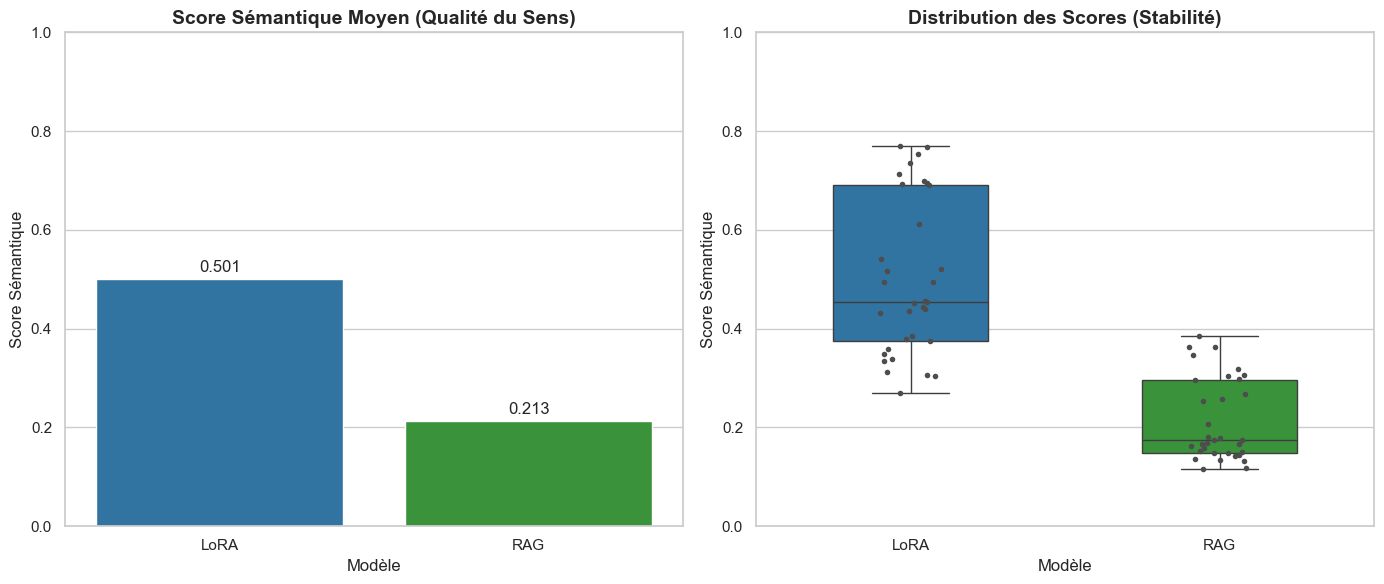

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# 1. Conversion en DataFrame
df_res = pd.DataFrame(results)

# ==============================================================================
# A. TABLEAU DES RÉSULTATS STYLISÉ
# ==============================================================================

def colorer_winner(val):
    """Colore le texte : Vert pour RAG, Bleu pour LoRA"""
    color = '#2ca02c' if val == 'RAG' else '#1f77b4'
    weight = 'bold'
    return f'color: {color}; font-weight: {weight}'

# Création du style
# CORRECTION ICI : Utilisation de 'RdYlGn' (Rouge -> Jaune -> Vert)
styled_df = df_res.style.format({
    'LoRA_Sem': '{:.3f}', 'RAG_Sem': '{:.3f}',
    'LoRA_Rouge': '{:.3f}', 'RAG_Rouge': '{:.3f}'
}).background_gradient(
    subset=['LoRA_Sem', 'RAG_Sem', 'LoRA_Rouge', 'RAG_Rouge'], 
    cmap='RdYlGn',   # <--- C'est ici que c'était faux
    vmin=0, vmax=1
).map(               # .applymap est déprécié, on utilise .map
    colorer_winner, subset=['Winner']
).set_properties(**{'text-align': 'center'})

print("📋 TABLEAU DÉTAILLÉ DES SCORES :")
display(styled_df)

# ==============================================================================
# B. GRAPHIQUES COMPARATIFS (Seaborn)
# ==============================================================================
# Préparation des données
df_melted = df_res.melt(
    id_vars=["Question", "Winner"], 
    value_vars=["LoRA_Sem", "RAG_Sem"], 
    var_name="Modèle", 
    value_name="Score Sémantique"
)
df_melted["Modèle"] = df_melted["Modèle"].replace({"LoRA_Sem": "LoRA", "RAG_Sem": "RAG"})

# Configuration du style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 6))

# 1. Barplot des Moyennes
plt.subplot(1, 2, 1)
# CORRECTION : Ajout de hue="Modèle" et legend=False pour éviter le warning
ax1 = sns.barplot(
    x="Modèle", y="Score Sémantique", hue="Modèle", data=df_melted, 
    palette=["#1f77b4", "#2ca02c"], errorbar=None, legend=False
)
plt.title("Score Sémantique Moyen (Qualité du Sens)", fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
for i in ax1.containers:
    ax1.bar_label(i, fmt='%.3f', padding=3)

# 2. Boxplot (Distribution)
plt.subplot(1, 2, 2)
# CORRECTION : Ajout de hue="Modèle" et legend=False
sns.boxplot(
    x="Modèle", y="Score Sémantique", hue="Modèle", data=df_melted, 
    palette=["#1f77b4", "#2ca02c"], width=0.5, legend=False
)
sns.stripplot(x="Modèle", y="Score Sémantique", data=df_melted, color=".3", size=4, jitter=True)
plt.title("Distribution des Scores (Stabilité)", fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

# ==============================================================================
# C. RÉSUMÉ EXÉCUTIF (HTML)
# ==============================================================================
avg_lora = df_res['LoRA_Sem'].mean()
avg_rag = df_res['RAG_Sem'].mean()
win_rate_rag = (df_res['Winner'] == 'RAG').mean() * 100

resume_html = f"""
<div style="background-color: #f8f9fa; border-left: 5px solid #6c757d; padding: 15px; margin-top: 20px;">
    <h3 style="margin-top:0;">📊 Bilan de l'évaluation</h3>
    <ul>
        <li><b>Score Sémantique Moyen LoRA :</b> {avg_lora:.4f}</li>
        <li><b>Score Sémantique Moyen RAG :</b> {avg_rag:.4f}</li>
        <li><b>Taux de victoire du RAG :</b> {win_rate_rag:.1f}%</li>
    </ul>
</div>
"""
display(HTML(resume_html))

<div style="background-color: #e7f3fe; border-left: 6px solid #2196F3; padding: 15px; color: #0c5460;">
    <strong>Observation :</strong> <br>
On se rend finalement compte qu'avec un petit modèle et sur des questions complexes, LoRA est plus performant que le RAG. </div>